In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import ase 
from ase.units import Bohr 
import torch
import metatensor
from metatensor import TensorMap, TensorBlock, Labels

In [3]:
import matplotlib.pyplot as plt

In [4]:
from ase.io import read 
from pyscf.pbc.tools import pyscf_ase 


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Check supercell $\Gamma$ and unit cell k-point calc/ generate translated matrices

In [5]:
from mlelec.data.pyscf_calculator import get_scell_phase, check_translation_hermiticity, map_gammapoint_to_kpoint, map_gammapoint_to_relativetrans

In [6]:
# load unit cell frame, create supercell and phase 
# filename = "C2_174_imx"
# framename = "C2_174.extxyz"

filename = "C2_rotated"
framename = "C2_rotated.xyz"
# filename = "examples/data/periodic/c2/C2_rotated"
# framename = "examples/data/periodic/c2/C2_rotated.xyz"
frames = read(framename, ':')
kmesh = [4, 4, 1]
fock_Ls = []
error = []
for ifr, frame in enumerate(frames[:]):
    cell, scell, phase = get_scell_phase(frame, kmesh)
    NR, Nk = phase.shape
    nao = cell.nao

    fock = np.load('results_{}/supercell/supercell_fock_{}.npy'.format(filename, ifr)).reshape(NR, nao, NR, nao)
    kkfock = np.load('results_{}/unitcell/unitcell_fock_{}.npy'.format(filename, ifr))

    overlap = np.load('results_{}/supercell/supercell_over_{}.npy'.format(filename, ifr)).reshape(NR, nao, NR, nao)
    kkoverlap = np.load('results_{}/unitcell/unitcell_over_{}.npy'.format(filename, ifr))

    check_translation_hermiticity(fock, NR=NR)
    # R_rel = translation_vectors_for_kmesh(cell, kmesh, wrap_around=False, return_rel=True)
    fock_trans, weights, phasediff = map_gammapoint_to_relativetrans(fock, phase=phase, cell=cell, kmesh=kmesh)
    yy = map_gammapoint_to_kpoint(fock, phase=phase, cell=cell, kmesh=kmesh)
    print(np.linalg.norm(yy - kkfock))
    error.append(np.linalg.norm(yy - kkfock))
    fock_Ls.append(fock_trans)


0.00010222087626684012
9.813485513377627e-05
0.00010211799044343512


[0 1 2]


(0.0, 0.001)

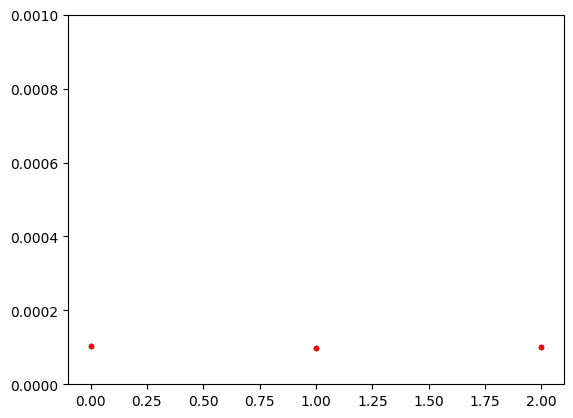

In [9]:
import matplotlib.pyplot as plt
large_err = np.where(np.array(error)>1e-5)[0]
print(large_err)
plt.plot(error, 'k.')
plt.plot(large_err, np.array(error)[large_err], 'r.')
plt.ylim(0, 1e-3)

In [10]:
import hickle
# hickle.dump(cell.make_kpts(kmesh), 'results_{}/kpts.hkl'.format(filename))
# hickle.dump(phasediff, 'results_{}/expkL.hkl'.format(filename))
# hickle.dump(weights, 'results_{}/weights.hkl'.format(filename))

In [11]:
# focks_translated = {key: np.asarray([dictionary[key] for dictionary in fock_Ls]) for key in fock_Ls[0].keys()}

# hickle.dump(focks_translated, 'results_{}/fock_Ls.hkl'.format(filename))

In [12]:
# merged_dict = {k: [] for k in fock_Ls[0].keys()} 
# for k in fock_Ls[0].keys():
#     for i in range(len(fock_Ls)):
#         merged_dict[k].append(fock_Ls[i][k])
# for x in merged_dict.keys():
#     no = np.linalg.norm(focks_translated[x] - np.array(merged_dict[x]))
#     if no > 1e-5:
#         print(x, no)
    

In [13]:
## For one structure explicit calc 

# frame = frames[0]
# cell, scell, phase = get_scell_phase(frame, kmesh)
# NR, Nk = phase.shape
# nao = cell.nao
# fock = np.load('results_C2_174_imx/supercell/supercell_fock_{}.npy'.format(7)).reshape(NR, nao, NR, nao)
# kkfock = np.load('results_C2_174_imx/unitcell/unitcell_fock_{}.npy'.format(7))

# H = {(i,j): fock[i,:,j,:] for i in range(NR) for j in range(NR)}
# R_rel = translation_vectors_for_kmesh(cell, kmesh, wrap_around=False, return_rel=True)
# # R_vec_abs = translation_vectors_for_kmesh(cell, kmesh, wrap_around=False)
# maps_Ls = defaultdict(list) 

# for i, (M,N) in enumerate(H.keys()):
#     maps_Ls[str(tuple((R_rel[M] - R_rel [N])))].append((M-N, M,N,i))

# maps_Ls = {k: v for k, v in maps_Ls.items() if v}

# H_maps_Ls = defaultdict(list)
# H_Ls = {}
# weight_Ls = {}
# phase_diff_Ls = {}  
# for i, k in enumerate(maps_Ls.keys()):
#     for x in maps_Ls[k]:
#         M, N = x[1], x[2]
#         H_maps_Ls[k].append((H[(M,N)]))
    
#     try: 
#         xx = H_maps_Ls[k][0]
#         for y in H_maps_Ls[k][1:]:
#             # print(np.linalg.norm(xx-y), k)
#             if not np.allclose(xx, y):
#                 print(k, np.linalg.norm(xx-y))
#         H_Ls[k] = xx
#         weight_Ls[k] = len(H_maps_Ls[k])
#         phase_diff_Ls[k] = np.array(phase[M]/ phase[N])
#     except:
#         print(k, "skipped")
# yy = np.zeros((Nk, nao, nao), dtype = np.complex128)

# for k in H_Ls.keys():
#     for j in range(Nk):
#         yy[j] += H_Ls[k] * weight_Ls[k] * phase_diff_Ls[k][j]

# for k in range(Nk):
#     print(np.linalg.norm(yy[k]/16 - kkfock[k].conj()))
# print(np.linalg.norm(yy/16 - kkfock.conj()))

# Learn

In [7]:
import hickle

In [214]:
# frames = read('C2_rotated.xyz', ':')
frames = read('examples/data/periodic/c2/C2_174.extxyz', ':10')
for f in frames:
    f.pbc = [True, True, True]

kmesh = [4, 4, 1]
# filename = "C2_rotated"
filename = "C2_174"
translated_matrices = hickle.load('examples/data/periodic/c2/results_{}/fock_Ls.hkl'.format(filename))
weights = hickle.load('examples/data/periodic/c2/results_{}/weights.hkl'.format(filename))
kpts = hickle.load('examples/data/periodic/c2/results_{}/kpts.hkl'.format(filename))  
expkL = hickle.load('examples/data/periodic/c2/results_{}/expkL.hkl'.format(filename))

In [215]:
for T in translated_matrices.keys():
    mT = tuple(-np.asarray(T))
    if not mT in translated_matrices.keys():
        raise ValueError("key not found")

    norm = np.linalg.norm(translated_matrices[T] - np.transpose(translated_matrices[mT], axes=(0,2,1)))
    if norm> 1e-10:
        print(T, norm)

In [216]:
Ls = np.asarray([list(k) for k in translated_matrices.keys()])

In [217]:
## Fix orbital order 
from mlelec.utils.twocenter_utils import fix_orbital_order
orbs = {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}
for T in translated_matrices.keys():
    translated_matrices[T] = fix_orbital_order(translated_matrices[T], frames, orbs)


In [218]:
positive_Ls = []
for L in Ls:
    lL  = list(L)
    lmL = list(-L)
    if not (lL in positive_Ls):
        if not (lmL in positive_Ls):
            positive_Ls.append(lmL)
print(len(positive_Ls), len(Ls)   )

25 49


In [219]:
# select a subset of positive translations
desired_shifts = [
    [0, 0, 0],
 [1, 0, 0],
 [0,1,0], 
 [1, 1, 0],
 [1,-1,0],
 [2,0,0], 
[0,2,0], 
[2,1,0],
[3,0,0],
[0,3,0],
 ]

# desired_shifts = Ls 

withnegative_shifts = desired_shifts.copy()
for s in withnegative_shifts[:]:
    withnegative_shifts.append([-s[0], -s[1], -s[2]])

selected_matrices = {}
for s in withnegative_shifts:
    selected_matrices[tuple(s)] = translated_matrices[tuple(s)]

# check hermiticity across translations
for s in desired_shifts[:]:
    if np.linalg.norm(selected_matrices[tuple(s)] - np.transpose(selected_matrices[tuple([-s[0], -s[1], -s[2]])], axes=(0,2,1)))/np.linalg.norm(selected_matrices[tuple(s)])> 1e-10:
        print(s)
        print(np.linalg.norm(selected_matrices[tuple(s)] - np.transpose(selected_matrices[tuple([-s[0], -s[1], -s[2]])], axes=(0,2,1)) ))
        print(np.linalg.norm(selected_matrices[tuple(s)] - np.transpose(selected_matrices[tuple([-s[0], -s[1], -s[2]])], axes=(0,2,1))) /np.linalg.norm(selected_matrices[str(s)]))
    # assert np.allclose(selected_matrices[str(s)], selected_matrices[str([-s[0], -s[1], -s[2]])].T)


In [220]:
zeroshift = translated_matrices[(0,0,0)]
np.linalg.norm(zeroshift - np.transpose(zeroshift, axes=(0,2,1)))

9.753175325980078e-16

In [221]:
# def get_minus_from_plus(block, shift=[0,0,1], pstarting=0 ):
#     if isinstance(shift, list):
#         shift = np.asarray(shift)
#     if sum(shift)%2 == 0:
#         return block
#     elif sum(shift)%2 == 0 and 0 in shift:
#         return block
    
#     elif not np.where(shift==0):
#         return block
    
#     else:
#         zeroindices = np.where(shift!=0)[0]
#         print(zeroindices)
#         minusblock = np.copy(block)
#         minusblock[:,pstarting+zeroindices] *= -1 # block[zeroindices[::-1]]
#         minusblock[pstarting+ zeroindices,:] *= -1
#         return minusblock
    

## proceed now 

In [222]:
from mlelec.utils.twocenter_utils import _to_blocks, _to_matrix, _to_coupled_basis, _to_uncoupled_basis


In [223]:

matrices_sum = {}
matrices_diff = {} 

for s in desired_shifts[:]:
    matrices_sum[tuple(s)] = 0.5*(selected_matrices[tuple(s)] + selected_matrices[tuple([-s[0], -s[1], -s[2]])])
    matrices_diff[tuple(s)] = 0.5* (selected_matrices[tuple(s)] - selected_matrices[tuple([-s[0], -s[1], -s[2]])])


In [224]:
for s in desired_shifts[:]:
    # print(np.linalg.norm(matrices_sum[tuple(s)] - matrices_sum[tuple(s)].transpose(0,2,1))) # SUM is hermitian  
    print(s, np.linalg.norm(matrices_diff[tuple(s)] + matrices_diff[tuple(s)].transpose(0,2,1)))  # DIFF is anti-hermitian

[0, 0, 0] 0.0
[1, 0, 0] 5.099858342432072e-15
[0, 1, 0] 5.770927957773908e-15
[1, 1, 0] 5.498412567973009e-15
[1, -1, 0] 2.9489205524771403e-16
[2, 0, 0] 9.65147161657606e-17
[0, 2, 0] 3.2663736944268525e-16
[2, 1, 0] 2.9478374749280746e-16
[3, 0, 0] 1.416424464350212e-15
[0, 3, 0] 5.049725970333229e-15


In [225]:
print('norm of Sum matrices')
for m in matrices_sum.values():
    print(np.linalg.norm(m))
print('norm of Diff matrices')
for m in matrices_diff.values():
    print(np.linalg.norm(m))

norm of Sum matrices
54.20150788504924
1.4703719767052015
4.612980281608163
4.675329803806235
0.11776329648441179
0.032072379274884905
0.21727649231106863
0.1207116869405447
1.470371976779733
4.6129802820905494
norm of Diff matrices
0.0
1.5896869020477293
4.665629333408246
4.725158746807788
0.11019695388278204
1.1926756280806283e-09
6.877182071136917e-10
0.11331812258631987
1.5896869020270719
4.665629333712581


In [226]:
target_blocks_sum = {}
target_blocks_minus = {}
target_coupled_blocks_sum = {}
target_coupled_blocks_diff= {}
for s in desired_shifts[:]:
    target_blocks_sum[tuple(s)] = _to_blocks(matrices_sum[tuple(s)], frames=frames, orbitals=orbs) # matrix -> uncoupled
    target_blocks_minus[tuple(s)] = _to_blocks(matrices_diff[tuple(s)], frames=frames, orbitals=orbs)
    target_coupled_blocks_sum[tuple(s)] = _to_coupled_basis(_to_blocks(matrices_sum[tuple(s)], frames=frames, orbitals=orbs), orbs) # uncouple -> coupled
    target_coupled_blocks_diff[tuple(s)] = _to_coupled_basis(_to_blocks(matrices_diff[tuple(s)], frames=frames, orbitals=orbs), orbs, skip_symmetry=True) # uncouple -> coupled



In [227]:
rsum = {}
rdiff = {}
rblocks_sum = {}
rblocks_minus = {}

for s in desired_shifts[:]:
    # rblocks_sum[tuple(s)] = _to_uncoupled_basis(target_coupled_blocks_sum[tuple(s)]) # couples-> uncoupled
    # rblocks_minus[tuple(s)] = _to_uncoupled_basis(target_coupled_blocks_diff[tuple(s)])

    # rsum[tuple(s)] = _to_matrix(target_blocks_sum[tuple(s)], frames = frames, orbitals=orbs) # uncoupled -> matrix
    # rdiff[tuple(s)] = _to_matrix(target_blocks_minus[tuple(s)], frames = frames, orbitals=orbs, hermitian=False)   
    rsum[tuple(s)] = _to_matrix(_to_uncoupled_basis(target_coupled_blocks_sum[tuple(s)]), frames = frames, orbitals=orbs)
    rdiff[tuple(s)] = _to_matrix(_to_uncoupled_basis(target_coupled_blocks_diff[tuple(s)]), frames = frames, orbitals=orbs, hermitian=False)

# matrix <-> uncoupled 

# this is now checking that matrix <-> uncoupled blocks works 
for s in desired_shifts[:]:
    assert torch.allclose(rsum[tuple(s)].cpu(), torch.from_numpy(matrices_sum[tuple(s)]).type(torch.float)),print("SUM", torch.linalg.norm(rsum[tuple(s)].cpu()- torch.from_numpy(matrices_sum[tuple(s)]).type(torch.float)))
   
    assert torch.allclose(rdiff[tuple(s)].cpu(), torch.from_numpy(matrices_diff[tuple(s)]).type(torch.float)) , print("DIFF",s, torch.linalg.norm(rdiff[tuple(s)].cpu()-torch.from_numpy(matrices_diff[tuple(s)]).type(torch.float)))
    # print(torch.linalg.norm(rsum[tuple(s)].cpu()- torch.from_numpy(matrices_sum[tuple(s)]).type(torch.float)))
    # print(torch.linalg.norm(rdiff[tuple(s)].cpu()-torch.from_numpy(matrices_diff[tuple(s)]).type(torch.float)))

In [228]:
# coupled -> uncoupled 
# for s in desired_shifts[:]:
#     for key, block in rblocks_sum[tuple(s)].items():
#         norm = np.linalg.norm(block.values.cpu().numpy() - target_blocks_sum[tuple(s)][key].values.cpu().numpy())
#         if norm> 1e-5:
#             print("SUM", s, key.values, norm)

# for s in desired_shifts[:]:
#     for key, block in rblocks_minus[tuple(s)].items():
#         li,lj= key["l_i"], key["l_j"]
#         norm = np.linalg.norm(block.values.cpu().numpy() - target_blocks_minus[tuple(s)][key].values.cpu().numpy())
#         if norm> 1e-5:
#             print("DIFF", s, key.values, norm)
#             break
#             print(block.values.cpu().numpy()[0])
#             print(target_blocks_minus[tuple(s)][key].values.cpu().numpy()[0]
#                     )

In [229]:
reconstructed_matrices = {} #sum/diff -> +T and -T 
for s in desired_shifts[:]:
    reconstructed_matrices[tuple(s)] = rsum[tuple(s)] + rdiff[tuple(s)]
    reconstructed_matrices[tuple(-np.asarray(s))] = rsum[tuple(s)] - rdiff[tuple(s)]
# reconstructed_matrices = get_predicted_matrices(rsum, rdiff)
for s in desired_shifts[:]:
    print(s, torch.linalg.norm(reconstructed_matrices[tuple(s)].cpu() - selected_matrices[tuple(s)]))

[0, 0, 0] tensor(1.2480e-06, dtype=torch.float64)
[1, 0, 0] tensor(9.7420e-08, dtype=torch.float64)
[0, 1, 0] tensor(3.3836e-07, dtype=torch.float64)
[1, 1, 0] tensor(3.3133e-07, dtype=torch.float64)
[1, -1, 0] tensor(1.1270e-08, dtype=torch.float64)
[2, 0, 0] tensor(2.1471e-09, dtype=torch.float64)
[0, 2, 0] tensor(1.3980e-08, dtype=torch.float64)
[2, 1, 0] tensor(1.1029e-08, dtype=torch.float64)
[3, 0, 0] tensor(9.6681e-08, dtype=torch.float64)
[0, 3, 0] tensor(3.3826e-07, dtype=torch.float64)


In [230]:
Nk = len(kpts)
nao = 10
small_shifts_target = []
for ifr, frame in enumerate(frames): 
    kmatrix = torch.zeros((Nk, nao, nao)).type(torch.complex128)

    # shift_indices = [np.where(np.all(Ls==np.asarray(s), axis=1))[0][0] for s in withnegative_shifts]
    for key in withnegative_shifts:
        key = tuple(key)
        for kpt in range(Nk):
            kmatrix[kpt] += translated_matrices[key][ifr] * weights[key] * expkL[key][kpt]
    kmatrix = kmatrix / Nk
    small_shifts_target.append(kmatrix) 
small_shifts_target = torch.stack(small_shifts_target).swapaxes(0,1)

### Equivariance check on target 

In [231]:
rotations = hickle.load('../mlelec/examples/data/water_rotated/rotations.hickle')

In [36]:
for i, 

TensorMap with 24 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          0           6       1    0       6       1    0   0
          0           6       1    0       6       2    0   0
                               ...
          -1          6       2    1       6       2    1   1
          -1          6       2    1       6       2    1   2

In [42]:
from mlelec.utils.metatensor_utils import labels_where
from mlelec.utils.symmetry import _wigner_d_real
import numpy as np
from metatensor import Labels
# r1 = target_coupled_blocks_diff
r1 = target_coupled_blocks_sum
for j, (shift, stmap) in enumerate(r1.items()):
    for i, (k,b) in enumerate(stmap.items()): 
        unrot_idx = labels_where(
            b.samples,
            selection=Labels(["structure"], values=np.asarray([[0]]).reshape(-1, 1)),
            return_idx=True,
        )[-1]
        rot_idx = labels_where(
            b.samples,
            selection=Labels(
                ["structure"], values=np.asarray([[1]]).reshape(-1, 1)
            ),
            return_idx=True,
        )[-1]
        L = k['L']
        # L = k["spherical_harmonics_l"]
        wd = _wigner_d_real(L, *rotations[1 -1]).to(b.values)
        if torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]) > 1e-7:
            print(torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]))

## TODO incorporate the plus minus as samples of the same translation and different translations as keys


## feature

In [232]:
from rascaline import SphericalExpansionByPair as PairExpansion
from rascaline import SphericalExpansion
from mlelec.utils.metatensor_utils import labels_where
from metatensor import Labels
from mlelec.features.acdc import twocenter_hermitian_features, single_center_features, pair_features, twocenter_hermitian_features_periodic
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys

In [269]:
hyper = {'cutoff': 4.,
          'max_radial':8, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
#test_rcut_shift: 
def test_rcut(frame, hypers, shifts):
    hypers_ij = hypers.copy()
    r = hypers['cutoff']
    cell = frame.cell.copy()
    norms = np.linalg.norm(frame.cell, axis=1)
    assert isinstance(shifts[0], tuple)
    max_shift = tuple([np.max(shifts, axis=(0,1))]*3)
    max_disp = np.sqrt(np.dot(max_shift, norms**2))+ frame.get_all_distances().max()**2
    if r < max_disp:
        hypers_ij['cutoff'] = max_disp    
    
    return hypers_ij

# hypers = test_rcut(frames[100], hyper, [(1,1,1)])
hypers = hyper
gij = PairExpansion(**hypers)
pair = gij.compute(frames)

# compute features that will be used for the zero shift
single = single_center_features(frames, hypers, 2, lcut=3)#, pca_final = True, npca = 0.9999, slice_samples = 4)
pair_zero_shift = pair_features(frames, hypers, order_nu=1,  all_pairs=True, lcut=3, max_shift=[1,1,1], feature_names = single.property_names)

# compute features that will be used for the other shifts
pair = pair_features(frames, hypers, order_nu=1,  all_pairs=True, lcut=3, max_shift=[3,3,1])

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:114: UserWarning: Using cutoff 2.0 for all pairs feature
  else:
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:114: UserWarning: Using cutoff 9.0 for all pairs feature
  else:


In [270]:

pair_feat = pair_zero_shift
blocks = []
for i, (key, block) in enumerate(pair_feat.items()):
    samples_lab, idx = labels_where(block.samples, selection=Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray([[0,0,0]]).reshape(-1, 3)), return_idx=True)
    # print(samples_lab.names)
    samples_lab =  Labels(samples_lab.names[:3], values=samples_lab.values[:,:3])
    tb = TensorBlock(
        samples=samples_lab,
        values=block.values[idx],
        properties=block.properties,
        components = block.components
    )
    blocks.append(tb)
pair_zero_shift = TensorMap(keys = pair_feat.keys, blocks=blocks)

zeroshift = twocenter_hermitian_features_periodic(single, pair_zero_shift, shift=[0,0,0])

In [235]:

# if desired_shifts is None: 
# Assume the first block has all the shifts
#     shifts = list(zip(pair[0].samples["cell_shift_a"], pair[0].samples["cell_shift_b"], pair[0].samples["cell_shift_c"]))
#     unique_shifts= list(set(shifts))
#     unique_shifts.sort()
#     zeroidx = unique_shifts.index((0,0,0))
#     nonneg_shifts = unique_shifts[zeroidx:]
#     desired_shifts = [list(x) for x in nonneg_shifts if not len(np.where(np.abs(np.asarray(x))>1)[0])]
    


In [271]:
# shifts = list(zip(pair[0].samples["cell_shift_a"], pair[0].samples["cell_shift_b"], pair[0].samples["cell_shift_c"]))
shifts = list(set(zip(pair[0].samples["cell_shift_a"], pair[0].samples["cell_shift_b"], pair[0].samples["cell_shift_c"])))

pair_sum = {str(x):[] for x in desired_shifts}
pair_diff = {str(x):[] for x in desired_shifts}
blocks_plus = []
blocks_minus = []

#treat zero shift separately - we just treat the zero shift samples as blocks_plus in feat_plus later

for i, (k,b) in enumerate(pair.items()):
    for shift in desired_shifts[1:]:
        minus_shift = tuple(-1*np.array(shift))
        slab, plusidx = labels_where(b.samples, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array(shift).reshape(1,-1)), return_idx=True)
        # print(len(plusidx))
        slabm, minusidx = labels_where(b.samples, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array(minus_shift).reshape(1,-1)), return_idx=True)
        # print(len(minusidx))

        #match samples ["structure", "center", "neighbor"] in blocks_plus and blocks_minus
        sidx = []
        try:
            for i, [structure, center, neighbor] in enumerate(slab.values[:,:3]):   
                sidx.append(np.where(np.all(slabm.values[:,:3] == [structure, center, neighbor], axis=1))[0][0])
            
        except:
            print(k, "skipped", slab.values.shape, slabm.values.shape)

        # print(slab.values.shape, slabm.values.shape)
        # print(len(sidx))
        if len(sidx) != slab.values.shape[0]:
            print(k, "PROBLEM", slabm.values, slabm.values)
        assert np.allclose(slab.values[:,:3], slabm.values[sidx][:,:3]), (k,slab.values[np.where(slab.values - slabm.values[sidx])[0]][:,:3], slabm.values[sidx][np.where(slab.values - slabm.values)[0]][:,:3]) # so its the same samples under consideration
        pvalues = b.values[plusidx] + b.values[minusidx]
        mvalues = b.values[plusidx] - b.values[minusidx]
        
        blocks_plus.append(TensorBlock(values = pvalues,
                                   components = b.components,
                             samples = Labels(names = pair.sample_names[:-3], values=np.asarray(b.samples.values[plusidx])[:,:-3]),
                                   properties = b.properties)
                            )
        
        blocks_minus.append(TensorBlock(values = mvalues,
                                   components = b.components,
                             samples = Labels(names = pair.sample_names[:-3], values=np.asarray(b.samples.values[plusidx])[:,:-3]),
                                   properties = b.properties)
                          )

In [272]:
print(len(blocks_plus), len(blocks_minus))
print("Must equal the product of the two values below")
print(len(pair.keys.values), len(desired_shifts[1:]))

63 63
Must equal the product of the two values below
7 9


In [273]:
import itertools
shift_trans = list(itertools.product(pair.keys.values.tolist(), desired_shifts[1:]))
shift_trans = [(list(itertools.chain.from_iterable(_))) for _ in shift_trans]
shift_trans_names = pair.keys.names  + pair.sample_names[-3:]
shift_trans = Labels(shift_trans_names, np.array(shift_trans))
pair_plus = TensorMap(shift_trans, blocks_plus)
pair_minus = TensorMap(shift_trans, blocks_minus)

In [274]:
len(pair_plus)

63

In [275]:
feat_plus=twocenter_hermitian_features_periodic(single, pair_plus) 
feat_minus=twocenter_hermitian_features_periodic(single, pair_minus, antisymmetric=True)

In [276]:
blocks = []
for i, (key, block) in enumerate(zeroshift.items()):
    property_names = feat_plus.property_names # feat_plus.property_names
    properties = Labels(property_names, values=block.properties.values)
    tb = TensorBlock(
        samples= block.samples, #Labels(sample_names, values=samp),
        values=block.values,
        properties=properties,
        components = block.components
    )
    blocks.append(tb)

key_names = zeroshift.keys.names[:-1] +["cell_shift_a", "cell_shift_b", "cell_shift_c", "block_type"]
keyvals = np.pad(zeroshift.keys.values, ((0,0),(0,3)))
print(keyvals.shape)
keyvals[:, [-4, -1]] = keyvals[:, [-1, -4]]
# keyvals = np.swapaxes(keyvals, -4,-1) # block typ to the last axis
keys = Labels(key_names, keyvals) 
zeroshift = TensorMap(keys = keys, blocks=blocks)

(21, 9)


In [277]:
block_plus_wzero = []
for k, b in zeroshift.items():
    block_plus_wzero.append(b.copy())
for k, b in feat_plus.items():
    block_plus_wzero.append(b.copy())
keyvals = np.concatenate((zeroshift.keys.values, feat_plus.keys.values))
print(keyvals.shape, len(block_plus_wzero))
keys = Labels(zeroshift.keys.names, keyvals )
feat_plus  = TensorMap(keys, block_plus_wzero)

(210, 9) 210


In [278]:
feat_minus

TensorMap with 189 blocks
keys: order_nu  inversion_sigma  spherical_harmonics_l  species_center  species_neighbor  cell_shift_a  cell_shift_b  cell_shift_c  block_type
         2             1                   0                  6                6               1             0             0            0
         2             1                   0                  6                6               0             1             0            0
                                                                        ...
         2            -1                   3                  6                6               0             3             0            1
         2            -1                   3                  6                6               0             3             0            -1

In [279]:
# labels_where(feat_plus.keys, selection=Labels(names=["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.array([1,1,1]).reshape(1,-1)), return_idx=True)

### Equivariance test on features 

In [151]:
from mlelec.utils.metatensor_utils import labels_where
from mlelec.utils.symmetry import _wigner_d_real
import numpy as np
from metatensor import Labels
# r1 = feat_plus
r1 = feat_minus 
for i, (k,b) in enumerate(r1.items()): 
    unrot_idx = labels_where(
        b.samples,
        selection=Labels(["structure"], values=np.asarray([[0]]).reshape(-1, 1)),
        return_idx=True,
    )[-1]
    rot_idx = labels_where(
        b.samples,
        selection=Labels(
            ["structure"], values=np.asarray([[1]]).reshape(-1, 1)
        ),
        return_idx=True,
    )[-1]
    # L = k['L']
    L = k["spherical_harmonics_l"]
    wd = _wigner_d_real(L, *rotations[1 -1]).to(b.values)
    if torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]) > 1e-7:
        print(k.values, torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]))
    # if torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]) / torch.linalg.norm(b.values[rot_idx])> 1e-6:
    #     print(k, torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx])/torch.linalg.norm(b.values[rot_idx]))

[2 1 3 6 6 0 1 0 0] tensor(1.0044e-07, device='cuda:0')
[2 1 2 6 6 1 1 0 1] tensor(1.1173e-07, device='cuda:0')
[ 2  1  3  6  6  0  1  0 -1] tensor(1.2971e-07, device='cuda:0')
[ 2  1  3  6  6  1  1  0 -1] tensor(1.1374e-07, device='cuda:0')


In [153]:
for s in desired_shifts[1:]:
    for k in target_coupled_blocks_sum[tuple(s)].keys:
        blockval = torch.linalg.norm(target_coupled_blocks_sum[tuple(s)][k].values)
        feat = map_targetkeys_to_featkeys(feat_plus, k, cell_shift=s)
        featval = torch.linalg.norm(feat.values)

        # print(s, k.values, blockval, featval)   
        if featval < 1e-5 and blockval > 1e-3:
            print(s, k.values, blockval, featval)
        # print(blockval, featval)   

for s in desired_shifts[1:]:
    for k in target_coupled_blocks_diff[tuple(s)].keys:
        blockval = torch.linalg.norm(target_coupled_blocks_diff[tuple(s)][k].values)
        if blockval>1e-5: 
            feat = map_targetkeys_to_featkeys(feat_minus, k, cell_shift=s)
            featval = torch.linalg.norm(feat.values)
            if featval < 1e-5 and blockval > 1e-3:
                print(s, k.values, blockval, featval)
            # print(s, k.values, blockval, featval)   
#         # print(blockval, featval)   

## train

In [249]:
from mlelec.models.linear import MLP
from mlelec.data.dataset import MLDataset, MoleculeDataset 

In [250]:
# dataset = MoleculeDataset(mol_name = "graphene", frames=frames, target = ['kfock'], target_data={'kfock': small_shifts_target}, orbs = "sto-3g")
# h_ml = MLDataset(dataset, )

## K T data loader 

In [ ]:
kdata = KpointData(frames, feat_plus, feat_minus,  small_shifts_target, selected_matrices , target_blocks_sum, target_blocks_minus )
# kdata._shuffle(720872)
kdata._split_indices(0.7, 0.2, 0.1)

NameError: name 'KpointData' is not defined

In [ ]:
import torch.utils.data as data 
from typing import Dict, List, Optional, Union
from torch.utils.data import Dataset, DataLoader
# from metatensor import TensorMap, Labels
import metatensor.operations as operations
import warnings

class KpointData(data.Dataset):
    def __init__(self, frames, feat_plus, feat_minus, target_kpoint, target_translation, target_blocks_sum, target_blocks_minus, target="target_translation" , device = "cuda"):
        self.frames = frames
        self.nstructs = len(frames)
        self.feat_plus = feat_plus 
        self.feat_minus = feat_minus
        self.features = {'plus': self.feat_plus, 'minus': self.feat_minus}
        self.target_kpoint = target_kpoint
        self.target_translation = target_translation
        if target == "target_translation":
            self.target = target_translation
        else: 
            self.target = target_kpoint
        # warnings.warn('Target set to', target)
        self.target_blocks_sum = target_blocks_sum
        self.target_blocks_minus = target_blocks_minus
        
        self.target_blocks = {'plus':self.target_blocks_sum, 'minus':self.target_blocks_minus}
        self.device = device
        self.indices = self.indices = torch.arange(self.nstructs)

    def _shuffle(self, random_seed: int = None):
        if random_seed is None:
            self.rng = torch.default_generator
        else:
            self.rng = torch.Generator().manual_seed(random_seed)

        self.indices = torch.randperm(self.nstructs, generator=self.rng)


    def _get_subset(self, y: TensorMap, indices: torch.tensor):
        assert isinstance(y, TensorMap)
        # for k, b in y.items():
        #     b = b.values.to(device=self.device)
        return operations.slice(
            y,
            axis="samples",
            labels=Labels(
                names=["structure"], values=np.asarray(indices).reshape(-1, 1)
            ),
        )

    def _split_indices(
        self, train_frac: float=None, val_frac: float=None, test_frac: Optional[float] = None
    ):
        #TODO: handle this smarter  

        # overwrite self train/val/test indices
        if train_frac is not None:
            self.train_frac = train_frac
        if val_frac is not None:
            self.val_frac = val_frac
        if test_frac is None:
            test_frac = 1 - (self.train_frac + self.val_frac)
            self.test_frac = test_frac
            assert self.test_frac > 0
        else: 
            try: 
                self.test_frac = test_frac
                assert np.isclose(self.train_frac + self.val_frac + self.test_frac, 1, rtol=1e-6, atol=1e-5), (
            self.train_frac + self.val_frac + self.test_frac, "Split fractions do not add up to 1"
        )
            except:
                self.test_frac = 1 - (self.train_frac + self.val_frac)
                assert self.test_frac > 0

        self.train_idx = self.indices[: int(self.train_frac * self.nstructs)]#.sort()[0]
        self.val_idx = self.indices[
            int(self.train_frac * self.nstructs) : int(
                (self.train_frac + self.val_frac) * self.nstructs
            )
        ]#.sort()[0]
        self.test_idx = self.indices[int((self.train_frac + self.val_frac) * self.nstructs) :]#.sort()[0]
        assert (
            len(self.test_idx)
            > 0  # and len(self.val_idx) > 0 and len(self.train_idx) > 0
        ), "Split indices not generated properly"
        self.target_train = self._get_subset(self.target_blocks, self.train_idx)
        self.target_val = self._get_subset(self.target_blocks, self.val_idx)
        self.target_test = self._get_subset(self.target_blocks, self.test_idx)

        self.train_frames = [self.structures[i] for i in self.train_idx]
        self.val_frames = [self.structures[i] for i in self.val_idx]
        self.test_frames = [self.structures[i] for i in self.test_idx]
       
       
        self.feature_names = self.features['plus'].keys.values
        self.feat_train = self._get_subset(self.features, self.train_idx)
        self.feat_val = self._get_subset(self.features, self.val_idx)
        self.feat_test = self._get_subset(self.features, self.test_idx)


    def _set_model_return(self, model_return: str = "blocks"):
        ## Helper function to set output in __get_item__ for model training
        assert model_return in [
            "blocks",
            "tensor",
        ], "model_target must be one of [blocks, tensor]"
        self.model_return = model_return

    def __len__(self):
        return len(self.frames) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            # idx = [i.item() for i in idx]
            idx = idx.tolist()
        if not self.model_type == "acdc":
            return self.structures[idx], self.target.tensor[idx]
        else:
            assert (
                self.features is not None
            ), "Features not set, call _set_features() first"
            x = operations.slice(
                self.features,
                axis="samples",
                labels=Labels(
                    names=["structure"], values=np.asarray([idx]).reshape(-1, 1)
                ),
            )
            if self.model_return == "blocks":
                y = operations.slice(
                    self.target.blocks,
                    axis="samples",
                    labels=Labels(
                        names=["structure"], values=np.asarray([idx]).reshape(-1, 1)
                    ),
                )
            else:
                idx = [i.item() for i in idx]
                y = self.target.tensor[idx]
            # x = metatensor.to(x, "torch")
            # y = metatensor.to(y, "torch")

            return x, y, idx

    def collate_fn(self, batch):
        x = batch[0][0]
        y = batch[0][1]
        idx = batch[0][2]
        return {"input": x, "output": y, "idx": idx}


def get_dataloader(
    ml_data: MLDataset,
    collate_fn: callable = None,
    batch_size: int = 4,
    drop_last: bool = False,
    selection: Optional[str] = "all",
    model_return: Optional[str] = None,
):
    assert selection in [
        "all",
        "train",
        "val",
        "test",
    ], "selection must be one of [all, train, val, test]"
    if collate_fn is None:
        collate_fn = ml_data.collate_fn

    assert model_return in [
        "blocks",
        "tensor",
    ], "model_target must be one of [blocks, tensor]"
    ml_data._set_model_return(model_return)
    train_sampler = data.sampler.SubsetRandomSampler(ml_data.train_idx)
    train_sampler = data.sampler.BatchSampler(
        train_sampler, batch_size=batch_size, drop_last=drop_last
    )

    val_sampler = data.sampler.SubsetRandomSampler(ml_data.val_idx)
    val_sampler = data.sampler.BatchSampler(
        val_sampler, batch_size=batch_size, drop_last=drop_last
    )

    test_sampler = data.sampler.SubsetRandomSampler(ml_data.test_idx)
    test_sampler = data.sampler.BatchSampler(
        test_sampler, batch_size=batch_size, drop_last=drop_last
    )
    train_loader = data.DataLoader(
        ml_data,
        sampler=train_sampler,
        collate_fn=collate_fn,
        shuffle=False,
    )
    val_loader = data.DataLoader(
        ml_data,
        sampler=val_sampler,
        collate_fn=collate_fn,
        shuffle=False,
    )

    test_loader = data.DataLoader(
        ml_data,
        sampler=test_sampler,
        collate_fn=collate_fn,
        shuffle=False,
    )
    if selection.lower() == "all":
        return train_loader, val_loader, test_loader
    elif selection.lower() == "train":
        return train_loader
    elif selection.lower() == "val":
        return val_loader
    elif selection.lower() == "test":
        return test_loader


## model 

In [280]:
import torch.nn as nn
class LinearModelPeriodic(nn.Module):
    def __init__(self, feat_plus, feat_minus, target_blocks_sum, target_blocks_diff, cell_shifts, frames, orbitals, device=None, **kwargs):
        super().__init__()
        self.feat_plus = feat_plus
        self.feat_minus = feat_minus
        self.target_blocks_sum = target_blocks_sum
        self.target_blocks_diff = target_blocks_diff
        self.cell_shifts = cell_shifts #Doesnt belong here #TODO extract this better 
        self.frames = frames
        self.orbitals = orbitals
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dummy_property = next(iter(self.target_blocks_sum.values()))[0].properties
        self._submodels(**kwargs)

    def _submodels(self, **kwargs):
        self.blockmodels = {}
        for s in self.cell_shifts: 
            shiftmodels ={}
            for k in self.target_blocks_sum[tuple(s)].keys:
                blockval = torch.linalg.norm(self.target_blocks_sum[tuple(s)][k].values)
                if blockval > 1e-5:
                    
                    feat = map_targetkeys_to_featkeys(self.feat_plus, k, cell_shift=s)
                    shiftmodels[str(tuple(k)+(1,))] = MLP(nin=feat.values.shape[-1], nout=1, nhidden=kwargs.get("nhidden",10), nlayers=kwargs.get("nlayers",2))
            if self.target_blocks_diff is not None:
                for k in self.target_blocks_diff[tuple(s)].keys:
                    blockval = torch.linalg.norm(self.target_blocks_diff[tuple(s)][k].values)
                    if blockval > 1e-5:
                        feat = map_targetkeys_to_featkeys(self.feat_minus, k, cell_shift=s)
                        shiftmodels[str(tuple(k)+(-1,))] = MLP(nin=feat.values.shape[-1], nout=1, nhidden=kwargs.get("nhidden",10), nlayers=kwargs.get("nlayers",2))
                    
            self.blockmodels[str(s)] = torch.nn.ModuleDict(shiftmodels)
        self.model = torch.nn.ModuleDict(self.blockmodels)
        self.model.to(self.device)

    def forward(self):
        self.recon_sum = {}
        if self.target_blocks_diff is not None:
            self.recon_diff = {} 
        else: 
            self.recon_diff = None
        for s in self.cell_shifts: 
            pred_blocks_sum = []
            pred_blocks_diff =[]
            for k in self.target_blocks_sum[tuple(s)].keys:
                blockval = torch.linalg.norm(self.target_blocks_sum[tuple(s)][k].values)
                if blockval > 1e-5:
                    feat = map_targetkeys_to_featkeys(self.feat_plus, k, cell_shift=s)
                    nsamples, ncomp, nprops = feat.values.shape
                    pred = self.blockmodels[str(s)][str(tuple(k)+(1,))](feat.values)
                    pred_blocks_sum.append( TensorBlock(
                    values=pred.reshape((nsamples, ncomp, 1)),
                    samples=self.target_blocks_sum[tuple(s)][k].samples,
                    components=self.target_blocks_sum[tuple(s)][k].components, #feat.components,
                    properties=self.dummy_property,
                    ))
                else: 
                    pred_blocks_sum.append(self.target_blocks_sum[tuple(s)][k].copy())
            pred_sum_tmap = TensorMap(self.target_blocks_sum[tuple(s)].keys, pred_blocks_sum)
            self.recon_sum[tuple(s)] = _to_matrix(_to_uncoupled_basis(pred_sum_tmap), frames = self.frames, orbitals=self.orbitals)
            if self.target_blocks_diff is not None:
                for k in self.target_blocks_diff[tuple(s)].keys:
                    blockval = torch.linalg.norm(self.target_blocks_diff[tuple(s)][k].values)
                    if blockval > 1e-5:
                        feat = map_targetkeys_to_featkeys(self.feat_minus, k, cell_shift=s)
                        nsamples, ncomp, nprops = feat.values.shape
                        pred = self.blockmodels[str(s)][str(tuple(k)+(-1,))](feat.values)
                        pred_blocks_diff.append( TensorBlock(
                        values=pred.reshape((nsamples, ncomp, 1)),
                        samples=self.target_blocks_diff[tuple(s)][k].samples, #feat.samples,
                        components=self.target_blocks_diff[tuple(s)][k].components, # feat.components,
                        properties=self.dummy_property,
                        ))

                    else:
                        pred_blocks_diff.append(self.target_blocks_diff[tuple(s)][k].copy())
            
                pred_diff_tmap = TensorMap(self.target_blocks_diff[tuple(s)].keys, pred_blocks_diff)   
            
            # self.recon_sum[tuple(s)] = _to_matrix(_to_uncoupled_basis(pred_sum_tmap), frames = self.frames, orbitals=self.orbitals)
                self.recon_diff[tuple(s)] = _to_matrix(_to_uncoupled_basis(pred_diff_tmap), frames = self.frames, orbitals=self.orbitals, hermitian=False)
        
        return self.recon_sum, self.recon_diff
    
    def fit_ridge_analytical(self) -> None:
        for shiftkey, model in self.models.item():
            for i, (k, submodel) in model.items():
                # feat = 
                feat_block = self.get_feature_block(
                    features=features, key=key, core_features=core_features
                )
                targ_block = targets[key]

                x = np.array(feat_block.values.reshape(-1, feat_block.values.shape[2]))
                y = np.array(targ_block.values.reshape(-1, 1))

                ridge = Ridge(alpha=self.alpha, fit_intercept=self.bias).fit(x, y)

                model.layer.weight = torch.nn.Parameter(
                    torch.from_numpy(ridge.coef_.copy().astype(np.float64))
                )
                

In [281]:
from typing import Union, List
def loss_zero_shift(pred, target, device=None):
    if device is None: 
        device = next(iter(pred.values())).device
    assert pred.keys() == target.keys()
    loss = 0
    
    loss += torch.sum((pred[tuple(s)]-target[tuple(s)])**2)
    return loss

def loss_fn_indiv_shift(rsum, rdiff, matrix_plust, matrix_minust, specific_shift_idx:Union[str, List]=None, device=None):
    #TODO: loss over particular shifts
    if device is None: 
        device = next(iter(rsum.values())).device
    # assert rsum.keys() == rdiff.keys()
    # assert rsum.keys() == matrix_plust.keys() # zero shift missing 
    weight_minus = 1
    weight_plus = 1
    if matrix_minust is not None:
        # assert rsum.keys() == matrix_minust.keys()
        if not isinstance(next(iter(matrix_minust.values())), torch.Tensor):
            matrix_minust = {k:torch.from_numpy(v).type(torch.float).to(device) for k,v in matrix_minust.items()}
    if not isinstance(next(iter(matrix_plust.values())), torch.Tensor):
        matrix_plust = {k:torch.from_numpy(v).type(torch.float).to(device) for k,v in matrix_plust.items()}
    loss = 0
    if isinstance(specific_shift_idx, list):
        raise NotImplementedError
    elif isinstance(specific_shift_idx, str):
        if specific_shift_idx == "positive":
            weight_minus=0
        elif specific_shift_idx == "negative":
            weight_plus=0
           
    for s in rsum.keys():
        if rdiff is not None:
            plust = rsum[tuple(s)] + rdiff[tuple(s)]
            minust = rsum[tuple(s)] - rdiff[tuple(s)]
        else: 
            plust = rsum[tuple(s)]
            minust = rsum[tuple(s)]
        loss += weight_plus*torch.sum((plust-matrix_plust[tuple(s)])**2) + weight_minus*torch.sum((minust-matrix_minust[tuple(s)])**2)

    return loss


def loss_fn_combined(rsum, rdiff, expkL:dict, complex_target, device = None):
    #TODO : support multiple k points 
    if device is None: 
        device = next(iter(rsum.values())).device
        complex_target = complex_target.to(device)
    assert rsum.keys() == rdiff.keys()
    matrix = {}
    for s in rsum.keys():
        matrix[tuple(s)] = rsum[tuple(s)] + rdiff[tuple(s)]
        matrix[tuple(-np.array(s))] = rsum[s] - rdiff[s]

    recon_target = torch.zeros_like(complex_target, requires_grad=True, dtype = torch.complex64, device = device)
    for s in matrix.keys():
         recon_target = recon_target+ matrix[s]*expkL[s]
    
    loss = torch.tensordot((recon_target-complex_target),torch.conj(recon_target-complex_target)) 
    # equivalent to torch.linalg.norm((recon_target-complex_target))**2
    assert torch.isclose(abs(loss), abs(loss.real))
    return loss.real

def get_predicted_matrices(rsum, rdiff, device=None):
    if device is None: 
        device = next(iter(rsum.values())).device
    assert rsum.keys() == rdiff.keys(), "rsum and rdiff must have same keys"
    matrix = {}
    for s in rsum.keys():
        # sint = [int(x) for x in s[1:-1].split(", ")]
        matrix[s] = rsum[s] + rdiff[s]
        matrix[tuple(-np.array(s))] = rsum[s] - rdiff[s]

    return matrix

In [282]:
model = LinearModelPeriodic( zeroshift, None, target_coupled_blocks_sum, None, desired_shifts[:1], frames, orbs, nhidden=16, nlayers=3)

In [287]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# # optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# # optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
# def closure():
#     optimizer.zero_grad()
#     rsum, rdiff = model.forward()
#     loss = loss_fn_indiv_shift(rsum, rdiff, matrices_sum, matrices_diff, specific_shift_idx = 'positive' )
#     loss.backward()
#     return loss

# losses = []
for i in range(1300):
    # loss = closure()
    # optimizer.step(closure)

    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    # print(rsum.keys())
    loss = loss_fn_indiv_shift(rsum, rdiff, matrices_sum, matrices_diff, specific_shift_idx = 'positive' )
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%10 ==0:
        print(i, loss.item())

0 0.0003953083069063723
10 0.0003858382988255471
20 0.00037969197728671134
30 0.0003737412625923753
40 0.0003678331268019974
50 0.00036227484815753996
60 0.00035727518843486905
70 0.00043549900874495506
80 0.0004191058105789125
90 0.00035224761813879013
100 0.000355529657099396
110 0.00033384672133252025
120 0.00032796338200569153
130 0.00032371701672673225
140 0.0004698431584984064
150 0.0005213679978623986
160 0.0005985862808302045
170 0.0003761534171644598
180 0.00031872763065621257
190 0.0003236045013181865
200 0.00030117708956822753
210 0.0002947057946585119
220 0.0002884854329749942
230 0.0002843063557520509
240 0.00028082949575036764
250 0.00027749736909754574
260 0.00027424393920227885
270 0.0002711306151468307
280 0.00026802613865584135
290 0.0002666277578100562
300 0.0005027313600294292
310 0.00038971786852926016
320 0.0006213482702150941
330 0.0003061413299292326
340 0.00026638031704351306
350 0.00026559620164334774
360 0.00024645542725920677
370 0.0002459342358633876
380 0.

KeyboardInterrupt: 

In [288]:
rsum_0 = model.forward()[0]

In [289]:
model = LinearModelPeriodic(feat_plus, feat_minus, target_coupled_blocks_sum, target_coupled_blocks_diff, desired_shifts[1:], frames, orbs, nhidden=16, nlayers=2)


In [290]:
# Norm the matrices before hand? but then how do we recover the actualm matrix

In [291]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
def closure():
    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    loss = loss_fn_indiv_shift(rsum, rdiff, matrices_sum, matrices_diff, specific_shift_idx = 'positive' )
    loss.backward()
    return loss

losses = []
for i in range(1300):
    # loss = closure()
    # optimizer.step(closure)

    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    loss = loss_fn_indiv_shift(rsum, rdiff, matrices_sum, matrices_diff, specific_shift_idx = 'positive' )
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%10 ==0:
        print(i, loss.item())

0 68.53742980957031
10 48.39392852783203
20 28.66879653930664
30 15.584948539733887
40 8.948714256286621
50 4.5619635581970215
60 2.0557236671447754
70 1.0691601037979126
80 0.46487534046173096
90 0.2473144829273224
100 0.1785847246646881
110 0.1247759610414505
120 0.10865583270788193
130 0.10135360062122345
140 0.09514949470758438
150 0.0898614302277565
160 0.08484591543674469
170 0.08012333512306213
180 0.07572506368160248
190 0.07157675176858902
200 0.06765581667423248
210 0.06394819170236588
220 0.06044171005487442
230 0.057127147912979126
240 0.05399477109313011
250 0.051035840064287186
260 0.048241935670375824
270 0.045605190098285675
280 0.043117962777614594
290 0.040773071348667145
300 0.03856339305639267
310 0.036482252180576324
320 0.03452315926551819
330 0.03267982602119446
340 0.030946258455514908
350 0.02931666374206543
360 0.02778547629714012
370 0.026347298175096512
380 0.02499706670641899
390 0.023729851469397545
400 0.02254086546599865
410 0.021425606682896614
420 0.02

In [292]:
rsum_final_plus, rdiff_final_plus = model.forward()
PLUS={}
for s in desired_shifts[1:]:
    PLUS[tuple(s)] = rsum_final_plus[tuple(s)] - rdiff_final_plus[tuple(s)]
    print(s, torch.linalg.norm(PLUS[tuple(s)].detach().cpu() - matrices_sum[tuple(s)]))

[1, 0, 0] tensor(0.0114, dtype=torch.float64)
[0, 1, 0] tensor(0.0206, dtype=torch.float64)
[1, 1, 0] tensor(0.0149, dtype=torch.float64)
[1, -1, 0] tensor(0.0003, dtype=torch.float64)
[2, 0, 0] tensor(0.0002, dtype=torch.float64)
[0, 2, 0] tensor(0.0008, dtype=torch.float64)
[2, 1, 0] tensor(0.0003, dtype=torch.float64)
[3, 0, 0] tensor(0.0211, dtype=torch.float64)
[0, 3, 0] tensor(0.0353, dtype=torch.float64)


In [293]:
model = LinearModelPeriodic(feat_plus, feat_minus, target_coupled_blocks_sum, target_coupled_blocks_diff, desired_shifts[1:], frames, orbs, nhidden=16, nlayers=2)

In [295]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1e-1, step_size_up=10, cycle_momentum=False)
# losses = []
for i in range(800):
    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    loss = loss_fn_indiv_shift(rsum, rdiff, matrices_sum, matrices_diff, specific_shift_idx = 'negative' )
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%10 ==0:
        print(loss.item())

0.038311250507831573
0.036352187395095825
0.03450614586472511
0.032767415046691895
0.031130407005548477
0.029589761048555374
0.02814016304910183
0.026776667684316635
0.025494370609521866
0.024288680404424667
0.023155121132731438
0.022089514881372452
0.021087804809212685
0.020146159455180168
0.019260942935943604
0.018428726121783257
0.01764625310897827
0.0169103741645813
0.016218237578868866
0.015567049384117126
0.01495424099266529
0.01437731459736824


KeyboardInterrupt: 

In [296]:
rsum_final_minus, rdiff_final_minus = model.forward()

In [297]:

# for s in desired_shifts[:]:
#     print(s, torch.linalg.norm(rsum_final_minus[tuple(s)].detach().cpu() - matrices_sum[tuple(s)]))
#     print(s, torch.linalg.norm(rdiff_final_minus[tuple(s)].detach().cpu() - matrices_diff[tuple(s)]))
# predicted_matrices = get_predicted_matrices(rsum_final_minus, rdiff_final_minus)
MINUS={}
for s in desired_shifts[1:]:
    MINUS[tuple(s)] = rsum_final_minus[tuple(s)] - rdiff_final_minus[tuple(s)]
    print(s, torch.linalg.norm(MINUS[tuple(s)].detach().cpu() - matrices_diff[tuple(s)]))


[1, 0, 0] tensor(0.0376, dtype=torch.float64)
[0, 1, 0] tensor(0.0375, dtype=torch.float64)
[1, 1, 0] tensor(0.0689, dtype=torch.float64)
[1, -1, 0] tensor(0.0013, dtype=torch.float64)
[2, 0, 0] tensor(0.0002, dtype=torch.float64)
[0, 2, 0] tensor(0.0002, dtype=torch.float64)
[2, 1, 0] tensor(0.0007, dtype=torch.float64)
[3, 0, 0] tensor(0.0447, dtype=torch.float64)
[0, 3, 0] tensor(0.0672, dtype=torch.float64)


In [298]:
hickle.dump(PLUS, "PLUS.hickle")
hickle.dump(MINUS, "MINUS.hickle")

/home/nigam/miniconda3/lib/python3.11/site-packages/hickle/lookup.py:1491: SerializedWarning: 'Tensor' type not understood, data is serialized:
  warnings.warn(


In [299]:

reconstruct_FIN = {}
for s in desired_shifts[1:]:
    reconstruct_FIN[tuple(s)] = PLUS[tuple(s)] + MINUS[tuple(s)] 
    reconstruct_FIN[tuple(-np.array(s))] = PLUS[tuple(s)] - MINUS[tuple(s)]

for s in desired_shifts[:1]:
    reconstruct_FIN[tuple(s)] = rsum_0[tuple(s)]

for s in reconstruct_FIN.keys():
    print(s, torch.linalg.norm(reconstruct_FIN[tuple(s)].detach().cpu() - selected_matrices[tuple(s)]), np.linalg.norm(selected_matrices[tuple(s)]))
# reconstruct_FIN = get_predicted_matrices(PLUS, MINUS)
# for s in desired_shifts[:]:
#     print(s, torch.linalg.norm(reconstruct_FIN[tuple(s)].detach().cpu() - selected_matrices[tuple(s)]))

(1, 0, 0) tensor(0.0393, dtype=torch.float64) 2.1654325656602817
(-1, 0, 0) tensor(0.0393, dtype=torch.float64) 2.165432565660281
(0, 1, 0) tensor(0.0428, dtype=torch.float64) 6.561073399624882
(0, -1, 0) tensor(0.0428, dtype=torch.float64) 6.561073399624881
(1, 1, 0) tensor(0.0706, dtype=torch.float64) 6.647242582973258
(-1, -1, 0) tensor(0.0705, dtype=torch.float64) 6.6472425829732575
(1, -1, 0) tensor(0.0013, dtype=torch.float64) 0.1612810052173518
(-1, 1, 0) tensor(0.0013, dtype=torch.float64) 0.16128100521735184
(2, 0, 0) tensor(0.0003, dtype=torch.float64) 0.03207237927488492
(-2, 0, 0) tensor(0.0003, dtype=torch.float64) 0.03207237927488493
(0, 2, 0) tensor(0.0008, dtype=torch.float64) 0.2172764923110687
(0, -2, 0) tensor(0.0008, dtype=torch.float64) 0.2172764923110686
(2, 1, 0) tensor(0.0007, dtype=torch.float64) 0.16556662788895682
(-2, -1, 0) tensor(0.0007, dtype=torch.float64) 0.16556662788895682
(3, 0, 0) tensor(0.0494, dtype=torch.float64) 2.1654325656957245
(-3, 0, 0) ten

## reconstruct k-point target 

In [300]:

recons_kpt_target = []
for ifr, frame in enumerate(frames): 
    kmatrix = torch.zeros((Nk, nao, nao)).type(torch.complex128)

    # shift_indices = [np.where(np.all(Ls==np.asarray(s), axis=1))[0][0] for s in withnegative_shifts]
    for key in withnegative_shifts:
        key = tuple(key)
        for kpt in range(Nk):
            kmatrix[kpt] += reconstruct_FIN[key][ifr].detach().cpu() * weights[key] * expkL[key][kpt]
    kmatrix = kmatrix / Nk
    recons_kpt_target.append(kmatrix) 
recons_kpt_target = torch.stack(recons_kpt_target).swapaxes(0,1)

In [301]:
for kpt in range(Nk):
    print(kpt, torch.linalg.norm(recons_kpt_target[kpt] - small_shifts_target[kpt]))
# torch.linalg.norm(recons_kpt_target - small_shifts_target)

0 tensor(0.0651, dtype=torch.float64)
1 tensor(0.1141, dtype=torch.float64)
2 tensor(0.0581, dtype=torch.float64)
3 tensor(0.1141, dtype=torch.float64)
4 tensor(0.1347, dtype=torch.float64)
5 tensor(0.1178, dtype=torch.float64)
6 tensor(0.1090, dtype=torch.float64)
7 tensor(0.1183, dtype=torch.float64)
8 tensor(0.0658, dtype=torch.float64)
9 tensor(0.1248, dtype=torch.float64)
10 tensor(0.0615, dtype=torch.float64)
11 tensor(0.1248, dtype=torch.float64)
12 tensor(0.1347, dtype=torch.float64)
13 tensor(0.1183, dtype=torch.float64)
14 tensor(0.1090, dtype=torch.float64)
15 tensor(0.1178, dtype=torch.float64)


In [ ]:
model = LinearModelPeriodic(feat_plus, feat_minus, target_coupled_blocks_sum, target_coupled_blocks_diff, desired_shifts, frames, orbs, nhidden=16, nlayers=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
losses = []
for i in range(300):
    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    loss = loss_fn_combined(rsum, rdiff, expkL_small, small_shifts_target)
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%10 ==0:
        print(loss.item())

0.16023802757263184
0.031491734087467194
0.009251020848751068
0.003096561646088958
0.0009399798000231385
0.0004689812776632607
0.00024364719865843654
0.00017960922559723258
0.00014655283303000033
0.00012858735863119364
0.0001240893907379359
0.00012232616427354515
0.00012163409701315686
0.00012134024291299284
0.00012129032984375954
0.00012125116336392239
0.00012124008208047599
0.00012123619671911001
0.00012123472697567195
0.0001212342904182151
0.00012123407941544428
0.00012123402848374099
0.00012123401393182576
0.00012123399937991053


KeyboardInterrupt: 